In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter

In [2]:
def d_arg(image_in, sz=1):
#     image_filt = gaussian_filter(image_in, sigma=sz)
    image_in = medfilt(image_in, kernel_size=sz)
    
    d_arg = np.zeros(image_in.shape)
    for i in range(4):
        
        # Rotate image in 90 deg increments, compute angle of gradient
        image_rot = np.rot90(image_in, i)
        grad_x,grad_y = np.gradient(image_rot)
        theta = np.arctan2(grad_y, grad_x)
        
        theta = gaussian_filter(theta, sigma=sz)
        
        # Compute change of angle of gradient in y direction (\alpha_{arg}, y_arg in direction 90*i)
        theta_grad_y = np.gradient(theta, axis=1)
        
        # Rotate back and add to total (accumulate darg)
        d_arg += np.rot90(theta_grad_y, -i)
    
        d_arg_2 = np.square(d_arg);
        d_arg_final = d_arg_2 / np.amax(d_arg_2) * 255
    
    return d_arg_final

<Figure size 432x288 with 0 Axes>

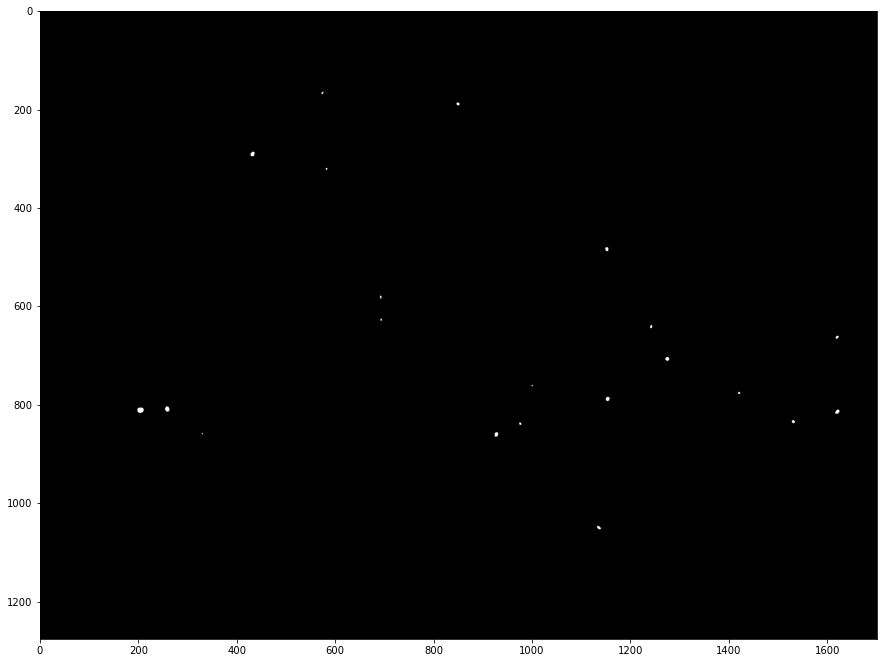

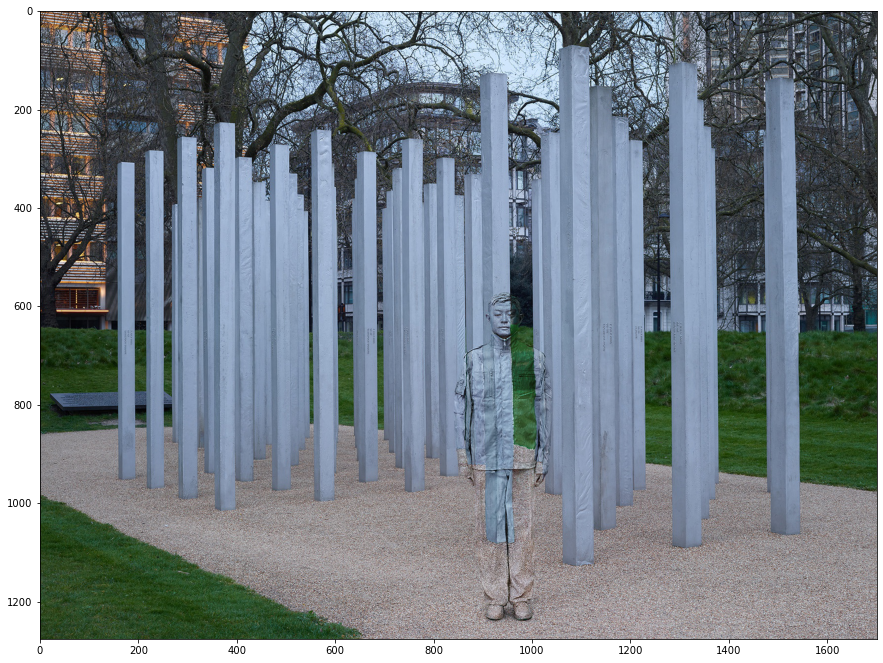

In [12]:
if __name__ == '__main__':
    # Load image
    plt.clf()
    image = cv2.imread("../Images/Images_from_Liu_Bolin_s_site/Liu1.jpg")
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Normalized paraboloid, for testing
#     x = np.arange(-100, 101)
#     X, Y = np.meshgrid(x, x);
#     Z = 2*np.square(X) + np.square(Y);
#     grayscale = Z / np.amax(Z);

    # Call method and show image
    image_out = d_arg(grayscale, 7).astype('uint8')
    _, masks = cv2.threshold(image_out, 0.65 * 255, 255, cv2.THRESH_BINARY)
    
    image_final = cv2.cvtColor(masks, cv2.COLOR_GRAY2RGB)
    plt.figure(figsize=(15,15))
    plt.imshow(image_final)
    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [13]:
# src = cv2.imread("../Images/Images_from_Liu_Bolin_s_site/Liu16.PNG")
# plt.imshow(src)

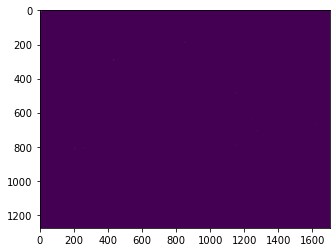

In [14]:
# Image sharpening
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)

imgLaplacian = cv2.filter2D(image, cv2.CV_32F, kernel)
sharp = np.float32(image)
image = sharp - imgLaplacian
# convert back to 8bits gray scale
image = np.clip(image, 0, 255)
image = image.astype('uint8')

# markers
dist_8u = masks.astype('uint8')
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
markers = np.zeros(masks.shape, dtype=np.int32)
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)
    
cv2.circle(markers, (5,5), 3, (255,255,255), -1)
plt.imshow(10000 * markers)

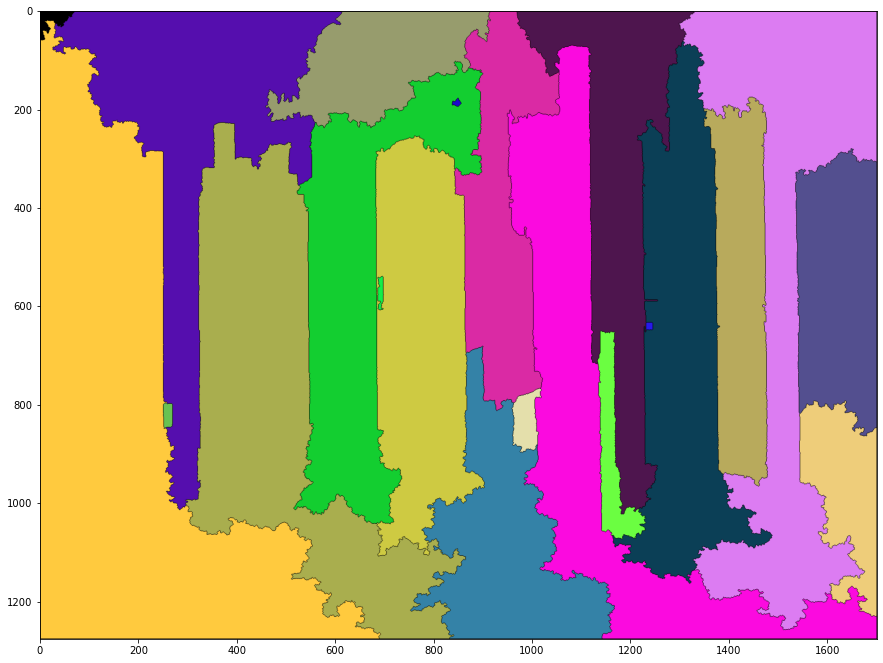

In [15]:
import random as rng

cv2.watershed(image, markers)

#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))